## Pressure-controlled

In [1]:
import pandas as pd
pd.options.display.max_rows = 160

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
import time
from sklearn import metrics

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

Columns
1. id - globally-unique time step identifier across an entire file
2. breath_id - globally-unique time step for breaths
3. R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
4. C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
5. time_step - the actual time stamp.
6. u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
7. u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
8. pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

## Overview Diagram

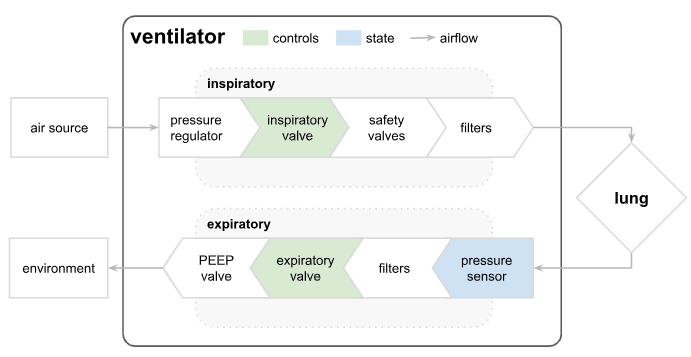

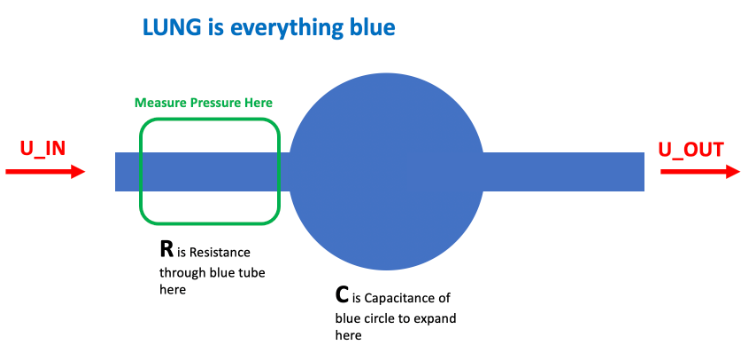

Note! In reality the entrance/exit of air through lung share the same pipeline <br>
1. The ventilator can measure pressure proximal to the expiratory valve during the inspiratory phase to approximate inspiratory proximal airway pressure, and
2. it can measure pressure distal to the inspiratory valve during the expiratory phase to approximate expiratory proximal airway pressure 

주의할 사항! 실제로 폐를 지나가는 공기의 입구/출구는 동일한 파이프라인을 공유합니다.
1. 인공호흡기는 흡기(inspiration) 단계에서 호기 밸브 근위부의 압력을 측정하여 흡기 근위부 기도 압력을 근사화할 수 있으며,
2. 호기(expiration) 단계에서 흡기 밸브 원위부의 압력을 측정하여 호기 근위 기도 압력을 근사화할 수 있습니다.

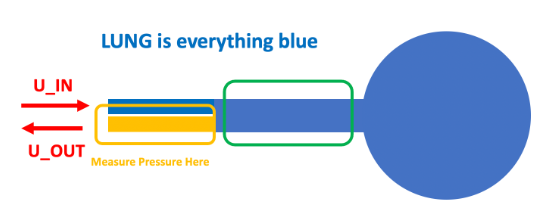

## What are R and C? How do they affect our target value Pressure? 

### Let's understand in Text

Higher the C, easier to blow the air (compliance, thickness) <br>
Higher the R, harder to blow the air (resistance, diameter) <br>

C가 높을수록 공기를 쉽게 불어넣을 수 있습니다(순응도, 두께). <br>
R이 높을수록 공기를 불어넣기 어렵습니다(저항, 직경).

The variable C is compliance and indicates how easy it is to stretch the balloon (lung). The largest value C=50 is the easiest to stretch. <br>
If we input air into a balloon that stretches easily, the pressure does not increase because the balloon just gets bigger (and thus air per space does not increase). <br>
If we input air into a ballon that does not stretch easy (C=10), the balloon stays the same size but gets more air inside (thus pressure increases). <br>

변수 C는 순응도이며 풍선(폐)을 얼마나 쉽게 늘릴 수 있는지를 나타냅니다. 가장 큰 값인 C=50이 가장 쉽게 늘어납니다. <br>
쉽게 늘어나는 풍선에 공기를 넣으면 풍선이 커질 뿐이므로(따라서 공기/공간이 증가하지 않으므로) 압력이 증가하지 않습니다. <br>
쉽게 늘어나지 않는 풍선(C=10)에 공기를 넣으면 풍선의 크기는 동일하게 유지되지만 내부에 더 많은 공기가 들어갑니다(따라서 압력이 증가합니다).

The variable R is resistance and indicates how easy it is for air to enter and then "exit" the balloon. <br> 
(Actually just move around since during inhale exit is closed). <br>
The largest value R=50 has the most resistance. If we input air into a balloon with high resistance, the air "stays inside" and increases pressure.

변수 R은 저항이며 공기가 풍선에 들어왔다가 "빠져나가기" 쉬운 정도를 나타냅니다. <br> 
(숨을 들이마시는 동안에는 출구가 닫혀 있기 때문에 실제로는 그냥 움직입니다). <br>
가장 큰 값인 R=50이 가장 큰 저항을 가집니다. 저항이 큰 풍선에 공기를 넣으면 공기가 "내부에 머물러" 압력이 높아집니다.

### Let's understand in Diagram

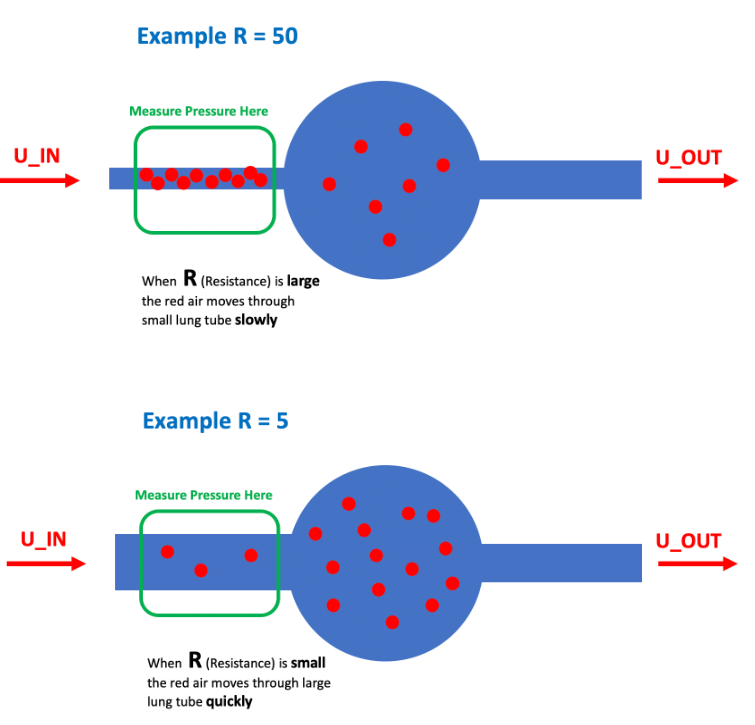

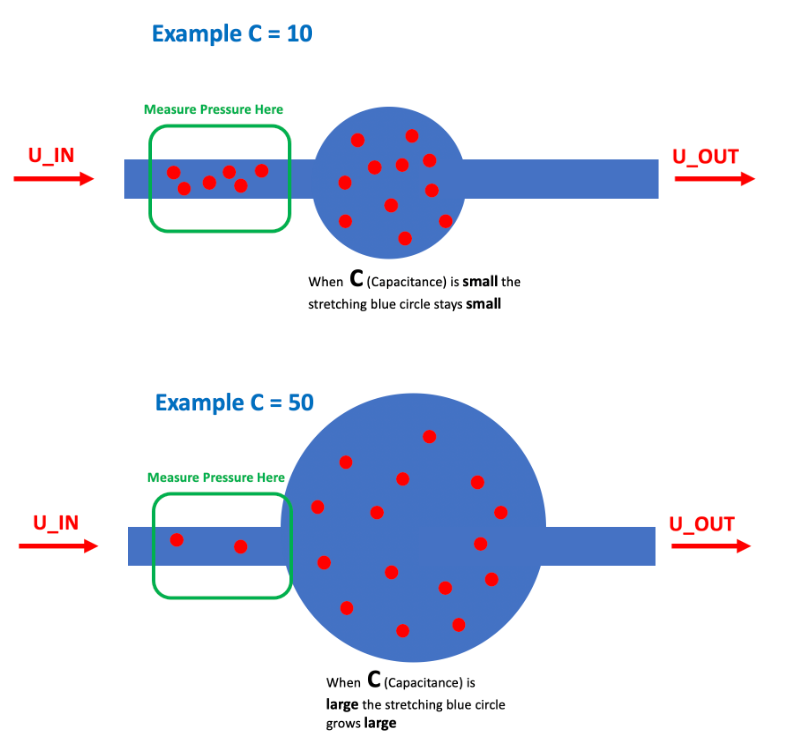

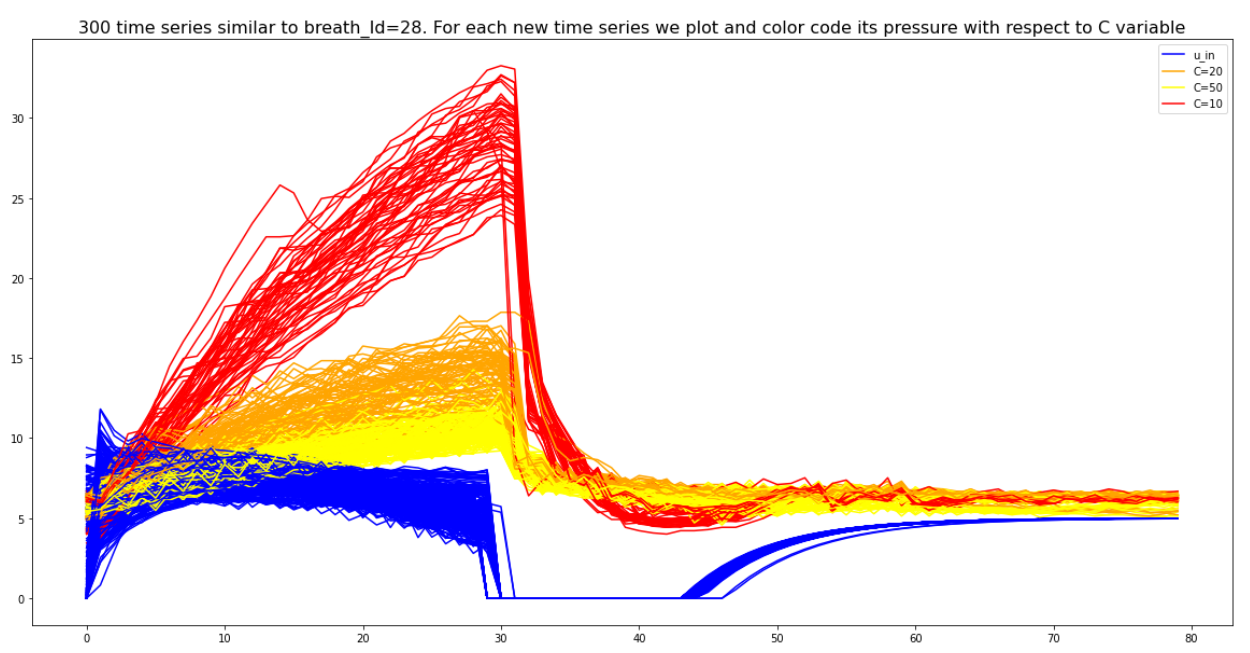

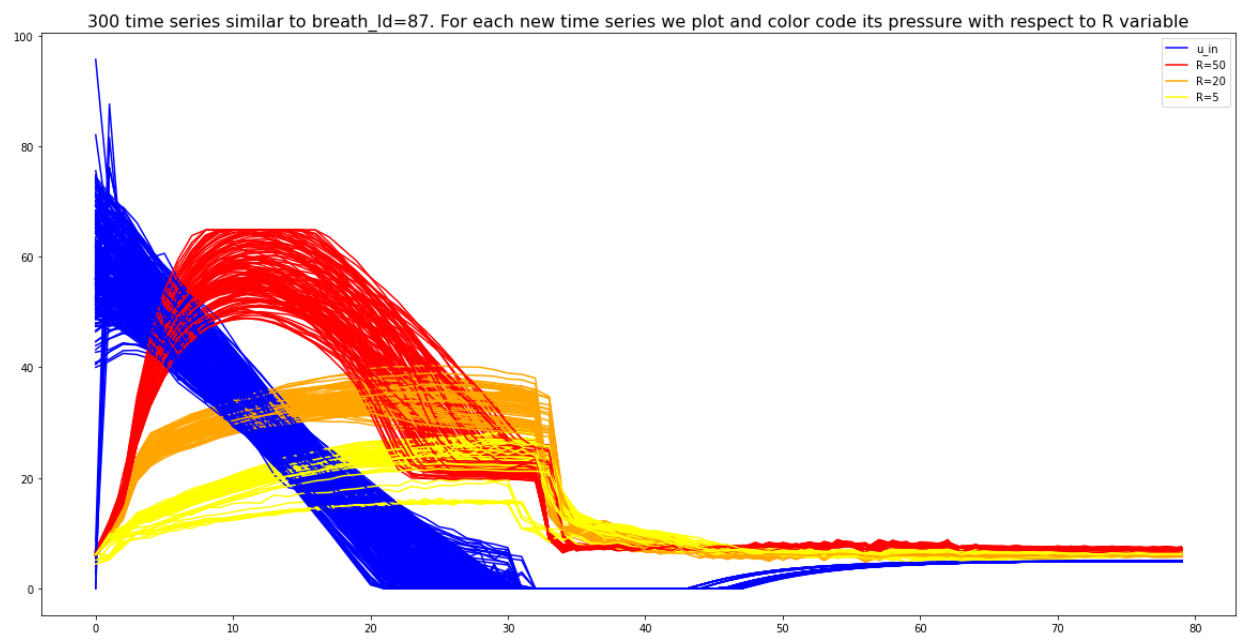

In [3]:
train.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094


In [4]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [5]:
train.R.value_counts(), train.C.value_counts()

(R
 50    2410080
 5     1988800
 20    1637120
 Name: count, dtype: int64,
 C
 10    2244720
 50    1971680
 20    1819600
 Name: count, dtype: int64)

In [6]:
test.R.value_counts(), test.C.value_counts()

(R
 50    1606800
 5     1306800
 20    1110400
 Name: count, dtype: int64,
 C
 10    1504800
 50    1315840
 20    1203360
 Name: count, dtype: int64)

In [7]:
def g(df):
    return df.groupby(['R', 'C']).size().to_frame(name='count').reset_index()

result = g(train.copy())

In [8]:
result.sort_values(by=['count'], ascending=False)

,R,C,count
6,50,10,1094160
0,5,10,664960
1,5,20,662160
2,5,50,661680
7,50,20,660800
8,50,50,655120
5,20,50,654880
4,20,20,496640
3,20,10,485600


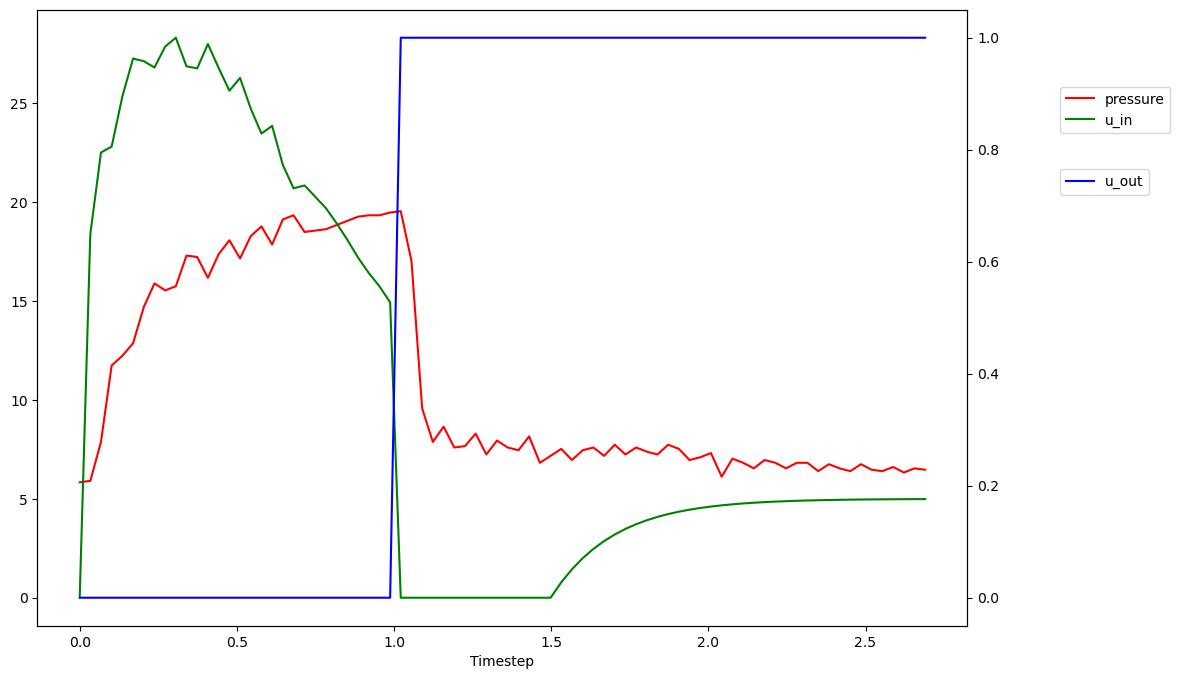

In [9]:
fig, ax1 = plt.subplots(figsize = (12, 8))

breath_1 = train.loc[train['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

날숨 -> u_in off for 0.5 seconds -> PEEP을 위해 다시 u_in 가동 (이게 아닐 수도 있다) <br>
보통 breath id 하나 당 3초인데, 들숨:날숨 비율을 1:2로 설정한다. 즉 날숨 시간 두배 <br>

Pressure는 총 두 개의 SP(target)가 있음 (들숨 SP 하나, 그리고 날숨 SP 하나)
1. 들숨 SP는 각 R, C combination마다 다르다
2. 날숨 SP도 각 R, C combination마다 다르다

왜냐하면 

In [10]:
len(breath_1)

80

Sampling Rate : 0.3 초

In [11]:
train.head(80)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094
